In [2]:
from google.colab import files
uploaded=files.upload()

Saving ADHD EEG DATA.xlsx - Sheet1 (1).csv to ADHD EEG DATA.xlsx - Sheet1 (1).csv


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Attention, Flatten, BatchNormalization, MaxPooling1D
from tensorflow.keras.utils import to_categorical

# Load the data
df1=pd.read_csv('HEALTHY CONTROL EEG DATA.xlsx - Sheet1 (1).csv')
df2=pd.read_csv('ADHD EEG DATA.xlsx - Sheet1 (1).csv')
data =pd.concat([df1, df2])

# Separate features and labels
X = data.drop(columns=['Class'])
y = data['Class']



X = X.apply(pd.to_numeric, errors='coerce')

# Fill or drop any missing values (if any)
X = X.fillna(0)  # You can choose a different strategy for handling missing values


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply ICA
ica = FastICA(n_components=63)  # Adjust the number of components as needed
X_ica = ica.fit_transform(X_scaled)

# Apply PCA
pca = PCA(n_components=19)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_ica)

# Reshape for Conv1D layer
X_pca = X_pca.reshape(X_pca.shape[0], X_pca.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_categorical, test_size=0.2, random_state=42)

# Define the model architecture
input_layer = Input(shape=(X_train.shape[1], 1))

# Add convolutional, normalization, and pooling layers
conv_layer1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
norm_layer1 = BatchNormalization()(conv_layer1)
pool_layer1 = MaxPooling1D(pool_size=2)(norm_layer1)

conv_layer2 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool_layer1)
norm_layer2 = BatchNormalization()(conv_layer2)
pool_layer2 = MaxPooling1D(pool_size=2)(norm_layer2)

# Add bidirectional LSTM layers
bi_lstm_layer1 = Bidirectional(LSTM(64, return_sequences=True))(pool_layer2)
bi_lstm_layer2 = Bidirectional(LSTM(64, return_sequences=True))(bi_lstm_layer1)

# Add attention layer
attention_layer = Attention()([bi_lstm_layer2, bi_lstm_layer2])

# Flatten the output and add the dense layer
flatten_layer = Flatten()(attention_layer)
output_layer = Dense(y_categorical.shape[1], activation='softmax')(flatten_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("accuracy score",accuracy_score(y_true, y_pred_classes))
# Print classification report and confusion matrix
print("Classification report")
print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion matrix")
print(confusion_matrix(y_true, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:582: UserWarning: n_components is too large: it will be set to 19
  warnings.warn(


Epoch 1/100
1139/1139 [==============================] - 36s 23ms/step - loss: 0.2782 - accuracy: 0.8822 - val_loss: 0.1712 - val_accuracy: 0.9316
Epoch 2/100
1139/1139 [==============================] - 26s 23ms/step - loss: 0.1364 - accuracy: 0.9471 - val_loss: 0.1200 - val_accuracy: 0.9525
Epoch 3/100
1139/1139 [==============================] - 25s 22ms/step - loss: 0.0962 - accuracy: 0.9631 - val_loss: 0.1136 - val_accuracy: 0.9585
Epoch 4/100
1139/1139 [==============================] - 26s 23ms/step - loss: 0.0761 - accuracy: 0.9713 - val_loss: 0.1070 - val_accuracy: 0.9600
Epoch 5/100
1139/1139 [==============================] - 25s 22ms/step - loss: 0.0626 - accuracy: 0.9765 - val_loss: 0.1025 - val_accuracy: 0.9604
Epoch 6/100
1139/1139 [==============================] - 27s 23ms/step - loss: 0.0505 - accuracy: 0.9810 - val_loss: 0.0842 - val_accuracy: 0.9719
Epoch 7/100
1139/1139 [==============================] - 26s 23ms/step - loss: 0.0404 - accuracy: 0.9846 - val_loss: 0

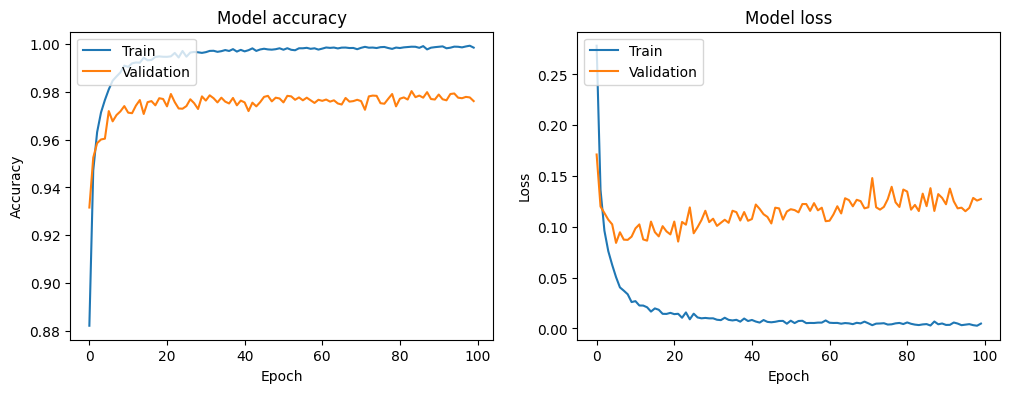

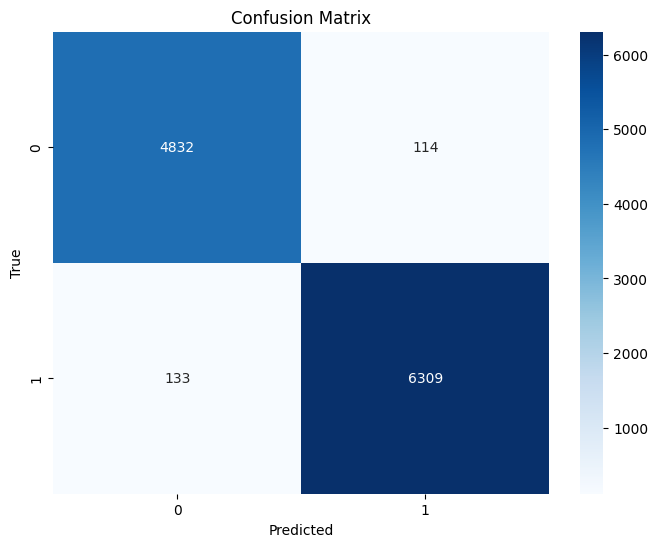

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Attention, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 19, 1)]              0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 17, 64)               256       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 17, 64)               256       ['conv1d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, 8, 64)                0         ['batch_normalization_4[

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Attention, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA, FastICA

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Attention, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


# Load the data
df1=pd.read_csv('HEALTHY CONTROL EEG DATA.xlsx - Sheet1 (1).csv')
df2=pd.read_csv('ADHD EEG DATA.xlsx - Sheet1 (1).csv')
data =pd.concat([df1, df2])


# Separate features and labels
X = data.drop(columns=['Class'])
y = data['Class']

X = X.apply(pd.to_numeric, errors='coerce')

# Fill or drop any missing values (if any)
X = X.fillna(0)  # You can choose a different strategy for handling missing values


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply ICA
ica = FastICA(n_components=63)  # Adjust the number of components as needed
X_ica = ica.fit_transform(X_scaled)

# Apply PCA
pca = PCA(n_components=15)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_ica)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_categorical, test_size=0.2, random_state=42)

# Define the model architecture
input_layer = Input(shape=(X_train.shape[1], 1))
conv_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
conv2_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
lstm_layer = Bidirectional(LSTM(28, return_sequences=True))(conv_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
flatten_layer = Flatten()(attention_layer)
output_layer = Dense(y_categorical.shape[1], activation='softmax')(flatten_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history=model.fit(X_train, y_train, epochs=100
        #  , batch_size=32, validation_split=0.2)





/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:589: UserWarning: n_components is too large: it will be set to 19
  warnings.warn(


Epoch 1/100
1139/1139 [==============================] - 18s 16ms/step - loss: 0.1280 - accuracy: 0.9499 - val_loss: 0.1408 - val_accuracy: 0.9461
Epoch 2/100
1139/1139 [==============================] - 19s 17ms/step - loss: 0.1263 - accuracy: 0.9510 - val_loss: 0.1398 - val_accuracy: 0.9457
Epoch 3/100
1139/1139 [==============================] - 18s 16ms/step - loss: 0.1265 - accuracy: 0.9494 - val_loss: 0.1408 - val_accuracy: 0.9440
Epoch 4/100
1139/1139 [==============================] - 19s 16ms/step - loss: 0.1234 - accuracy: 0.9512 - val_loss: 0.1498 - val_accuracy: 0.9427
Epoch 5/100
1139/1139 [==============================] - 20s 17ms/step - loss: 0.1227 - accuracy: 0.9513 - val_loss: 0.1506 - val_accuracy: 0.9403
Epoch 6/100
1139/1139 [==============================] - 18s 16ms/step - loss: 0.1219 - accuracy: 0.9526 - val_loss: 0.1375 - val_accuracy: 0.9471
Epoch 7/100
1139/1139 [==============================] - 19s 16ms/step - loss: 0.1211 - accuracy: 0.9529 - val_loss: 0

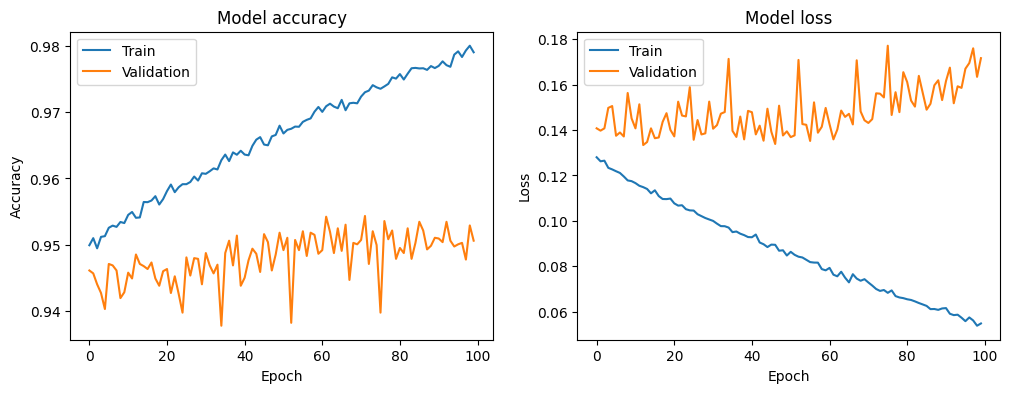

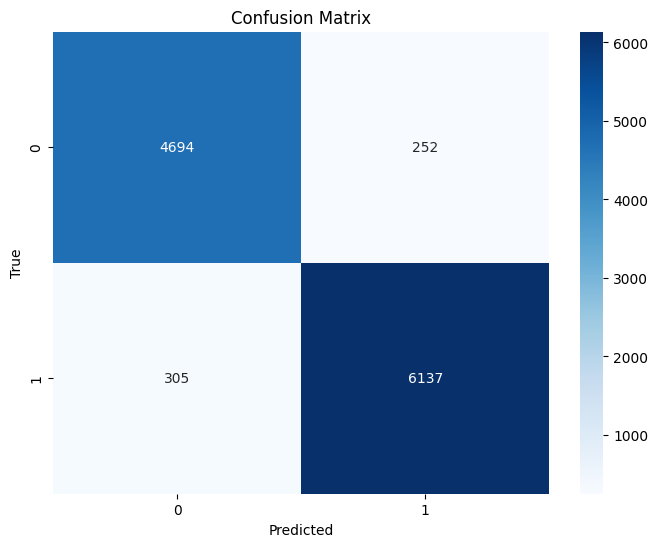

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, classification report, and confusion matrix
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy Score:", accuracy)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# performance comparison with other classifiers


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from tensorflow.keras.utils import to_categorical

df1=pd.read_csv('HEALTHY CONTROL EEG DATA.xlsx - Sheet1 (1).csv')
df2=pd.read_csv('ADHD EEG DATA.xlsx - Sheet1 (1).csv')
data =pd.concat([df1, df2])


# Separate features and labels
X = data.drop(columns=['Class'])
y = data['Class']

X = X.apply(pd.to_numeric, errors='coerce')

# Fill or drop any missing values (if any)
X = X.fillna(0)  # You can choose a different strategy for handling missing values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# SVM model
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))

# KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))

# Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))

# Prepare data for neural networks
X_train_nn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_nn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

# LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_nn.shape[1], 1)),
    Dense(y_train_nn.shape[1], activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, verbose=0)
lstm_pred = np.argmax(lstm_model.predict(X_test_nn), axis=1)
print("LSTM Accuracy:", accuracy_score(y_test, lstm_pred))
print("LSTM Classification Report:")
print(classification_report(y_test, lstm_pred))

# 1D CNN model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_nn.shape[1], 1)),
    Flatten(),
    Dense(y_train_nn.shape[1], activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, verbose=0)
cnn_pred = np.argmax(cnn_model.predict(X_test_nn), axis=1)
print("1D CNN Accuracy:", accuracy_score(y_test, cnn_pred))
print("1D CNN Classification Report:")
print(classification_report(y_test, cnn_pred))

# BiLSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(64), input_shape=(X_train_nn.shape[1], 1)),
    Dense(y_train_nn.shape[1], activation='softmax')
])
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bilstm_model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, verbose=0)
bilstm_pred = np.argmax(bilstm_model.predict(X_test_nn), axis=1)
print("BiLSTM Accuracy:", accuracy_score(y_test, bilstm_pred))
print("BiLSTM Classification Report:")
print(classification_report(y_test, bilstm_pred))


SVM Accuracy: 0.9731296101159115
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4946
           1       0.96      0.99      0.98      6442

    accuracy                           0.97     11388
   macro avg       0.97      0.97      0.97     11388
weighted avg       0.97      0.97      0.97     11388

KNN Accuracy: 0.9652265542676501
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4946
           1       0.95      0.99      0.97      6442

    accuracy                           0.97     11388
   macro avg       0.97      0.96      0.96     11388
weighted avg       0.97      0.97      0.97     11388

Naive Bayes Accuracy: 0.6176677204074464
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.64      0.59      4946
           1       0.69      0.60      0.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 15, 1)]              0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 13, 64)               256       ['input_2[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 13, 56)               20832     ['conv1d_2[0][0]']            
 onal)                                                                                            
                                                                                                  
 attention_1 (Attention)     (None, 13, 56)               0         ['bidirectional_2[0][0]'